In [20]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('../utils')
import mutation_score
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.gridspec import GridSpec

In [21]:
# Calculate distances between pairs of data points.
def calculate_distances(data, pairs):
    distances = []
    for pair in pairs:
        distance = np.abs(data[pair[0]] - data[pair[1]])
        distances.append(distance)
    return np.array(distances)

In [22]:
# Plot the data with a scatter plot and a best fit line.
def plot_data(ax, x, y, title, xlabel, ylabel, legend, categorized):
    x_array = np.array(x)  
    y_array = np.array(y) 
    correlation_coefficient = np.corrcoef(x_array, y_array)[0, 1]
    slope, intercept = np.polyfit(x_array, y_array, 1)
    best_fit_y = slope * x_array + intercept
    ax.scatter(x_array, y_array, color='black', alpha=0.25, label='Data Points')
    ax.plot(x_array, best_fit_y, color='black', label='Best Fit Line')
    ax.set_title(title.format(correlation_coefficient), fontsize =10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if categorized: ax.set_ylim(0.5, 5.5)
    if legend: ax.legend()
    ax.grid(True)

In [23]:
def plot_scatter_plots(ax, distances, scores_list, title):
    """Plot scatter plots for amino acid properties."""
    plot_data(ax, distances, scores_list, title, 'X', 'Y', False, True)

In [24]:
# Define plotting functions
def plot_bar_chart(ax, matrix_names, correlation_coefficients, description):
    """Plot a bar chart based on the given data and description."""
    alpha_value = 0.85 if description == "All" else 0.5
    bars = ax.bar(matrix_names, correlation_coefficients, color="black", alpha=alpha_value)
    
    # Set labels and titles based on the description
    if description == "All": 
        ax.set_ylabel('Sum of Pearson\ncorrelation coefficients', fontsize=10)
        ax.set_title('D) Ranking of substitution matrices based on their correlation with the eight biophysical properties', fontsize=12)
    elif description == "Hydrophobicity":
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize=10)
        ax.set_title('A) Ranking of substitution matrices based on their correlation with the side chain hydrophobicity property', fontsize=12)
    elif description == "Polarity":
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize=10)
        ax.set_title('B) Ranking of substitution matrices based on their correlation with the polarity property', fontsize=12)
    elif description == "Volumes":
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize=10)
        ax.set_title('C) Ranking of substitution matrices based on their correlation with the volume of the side chain', fontsize=12)
    else:
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize=10)
        ax.set_title(f'{description}', fontsize=12)
    
    # Customize x-axis
    ax.set_xticks(range(len(matrix_names)))
    ax.set_xticklabels(matrix_names, rotation=90, fontsize=8)
    
    # Add data labels on bars
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)
    
    # Set y-limits
    ylim = max(correlation_coefficients) + (1.5 if description == "All" else 0.4)
    ax.set_ylim(0, ylim)
    ax.set_xlim(-1, len(matrix_names))

In [25]:
def plot_mutational_impact(ax, sorted_scores):
    """Plot the mutational impact categorized score distribution."""
    for key, value in sorted_scores:
        ax.plot([key, key], [0, value], 'k-', lw=1)
        ax.plot(key, value, 'ko', markersize=3)
    
    # Customize x-axis
    ax.set_xticks([k for k, _ in sorted_scores])
    ax.set_xticklabels([f'{k[0]}-{k[1]}' for k, _ in sorted_scores], rotation=90, fontsize=5)
    
    # Set labels and title
    ax.set_ylabel('Scores')
    ax.set_xlabel('Amino acid changes')
    ax.set_title('F) Mutational impact categorized score distribution')
    
    # Set y-limits and y-ticks
    ax.set_ylim([0, 5.25])
    ax.set_xlim([-1, len(sorted_scores)])
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1', '2', '3', '4', '5'])

In [26]:
# Function to compute the Hamming distance between two codons
def compute_codon_distance(codon1, codon2):
    return sum(base1 != base2 for base1, base2 in zip(codon1, codon2))

In [27]:
# Function to identify the minimum codon distance between two amino acids
def identify_min_codon_distance(aa1, aa2, aa_to_codons):
    codons_aa1 = aa_to_codons[aa1]
    codons_aa2 = aa_to_codons[aa2]
    return min((compute_codon_distance(codon1, codon2) for codon1 in codons_aa1 for codon2 in codons_aa2), default=0)

In [28]:
# Function to isort the results
def sort_results(results):
    """Sorts results based on the correlation coefficient."""
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    return sorted_results

In [35]:
# Map of amino acids to their respective codons
CODON_TABLE = {'H': ['CAC', 'CAT'], 
 'P': ['CCA', 'CCC', 'CCG', 'CCT'], 
 'F': ['TTC', 'TTT'], 'M': ['ATG'], 
 'V': ['GTA', 'GTC', 'GTG', 'GTT'], 
 'A': ['GCA', 'GCC', 'GCG', 'GCT'], 
 'W': ['TGG'], 'N': ['AAC', 'AAT'], 
 'Y': ['TAC', 'TAT'], 
 'T': ['ACA', 'ACC', 'ACG', 'ACT'], 
 'G': ['GGA', 'GGC', 'GGG', 'GGT'], 
 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'], 
 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 
 'Q': ['CAA', 'CAG'], 'D': ['GAC', 'GAT'], 
 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'], 
 'C': ['TGC', 'TGT'], 'E': ['GAA', 'GAG'], 
 'I': ['ATA', 'ATC', 'ATT'], 
 'K': ['AAA', 'AAG']}

# List of standard amino acids
AMINO_ACIDS = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", 
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Generate all possible pairs of amino acids
pairs = [''.join(pair) for pair in combinations(AMINO_ACIDS, 2)]

# # Compute the minimum codon distances for each pair of amino acids
minimum_codon_distances = {pair: identify_min_codon_distance(pair[0], pair[1], CODON_TABLE) for pair in pairs}

# Load amino acid properties from an Excel file
df = pd.read_excel("amino_acid_properties.xlsx")
# Create a dictionary mapping each property to its corresponding values for each amino acid
amino_acid_properties = {col: df.set_index('Amino Acid')[col].to_dict() for col in df.columns if col != 'Amino Acid'}
# Create a DataFrame to represent amino acid changes
amino_acid_changes_df = pd.DataFrame({'Amino_Acid_Changes': pairs})
# Retrieve the names of substitution matrix files from a directory, excluding the file extension
json_files = [file[:-5] for file in os.listdir("../utils/substitution_matrices") if file.endswith('.json')]

# Analyze each substitution matrix to find the best one considering changes of amino acids biophysical properties
results = []
results_volumes = []
results_polarity = []
results_hydrophobicity = []

for json_file in json_files:
    # Categorize scores for each amino acid change using the scaled substitution matrix
    scores = mutation_score.get_mutational_scores(amino_acid_changes_df['Amino_Acid_Changes'], json_file, True)
    # Initialize total sum
    total = 0

    # Loop through each property value in the amino acid properties dictionary
    for key, value in amino_acid_properties.items():
        # Calculate the distances for the current property across all amino acid pairs
        distances = calculate_distances(value, pairs)
        
        # Prepare a list of scores corresponding to each pair
        scores_for_pairs = []
        for pair in pairs:
            scores_for_pairs.append(scores[pair])
        
        # Calculate the correlation coefficient matrix for distances and scores
        correlation_matrix = np.corrcoef(distances, scores_for_pairs)
        
        # Extract the correlation coefficient from the matrix (index [0, 1] or [1, 0])
        correlation_coefficient = correlation_matrix[0, 1]
        
        # Add the correlation coefficient to the total
        total += correlation_coefficient

        if key == "Hydrophobicity of side chain": results_hydrophobicity.append((json_file, correlation_coefficient))
        elif key == "Polarity": results_polarity.append((json_file, correlation_coefficient))
        elif key == "Volume of side chain": results_volumes.append((json_file, correlation_coefficient))

    # Compute the correlation coefficient for minimum codon distances
    min_codon_distances = [minimum_codon_distances[pair] for pair in pairs]
    mincod_correlation = np.corrcoef(min_codon_distances, [scores[pair] for pair in pairs])[0, 1]
    total += mincod_correlation
    results.append((json_file, total))

# Sort each results set
sorted_results = sort_results(results)
sorted_hydrophobicity = sort_results(results_hydrophobicity)
sorted_polarity = sort_results(results_polarity)
sorted_volumes = sort_results(results_volumes)
selected_substitution_matrix = sorted_results[0][0]
#substitution_matrix_dictionary = adjust_substitution_matrix(scale_substitution_matrix_values(load_substitution_matrix(selected_substitution_matrix)), selected_substitution_matrix)
categorized_scores = scores = mutation_score.get_mutational_scores(amino_acid_changes_df['Amino_Acid_Changes'], categorize=True)

# Data and titles for plotting
data = [(sorted_hydrophobicity, 'Hydrophobicity'), (sorted_polarity, 'Polarity'), (sorted_volumes, 'Volumes'), (sorted_results, 'All')]

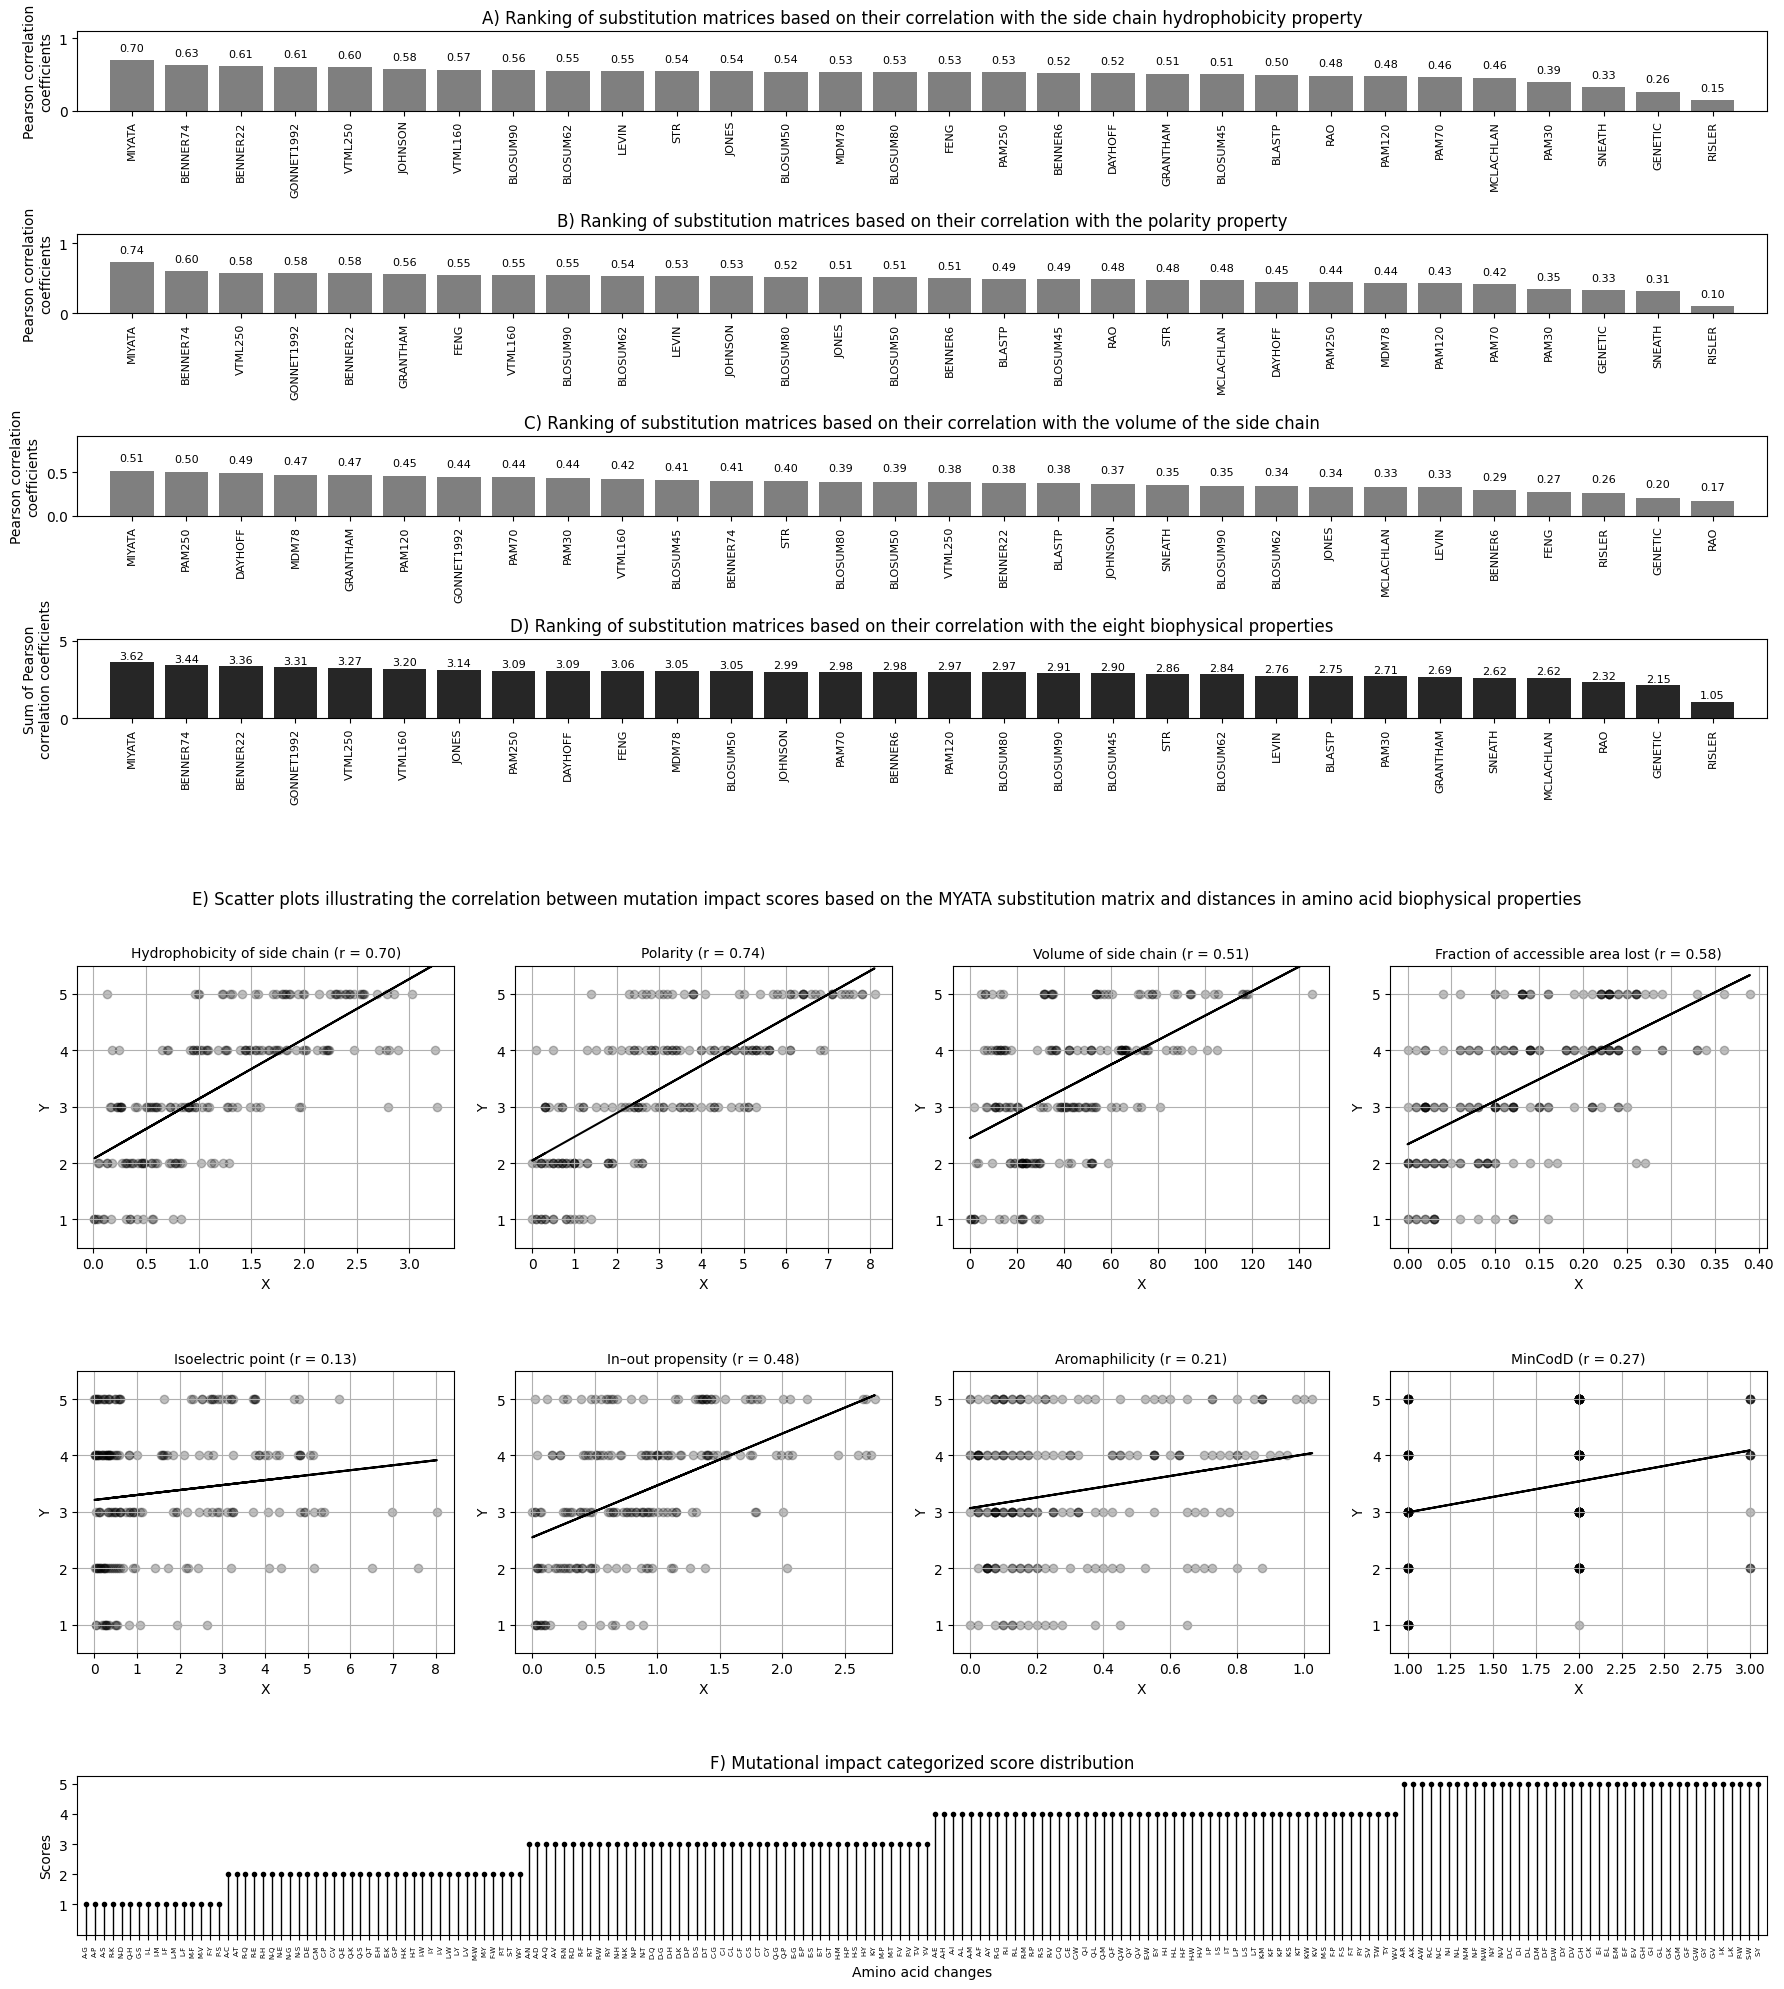

In [13]:
# Configuration
fig = plt.figure(figsize=(18, 20))
height_ratios = [1, 1, 1, 1, 0.01, 1, 1, 1, 1, 2]
gs = GridSpec(10, 4, figure=fig, height_ratios=height_ratios)

# Plot bar charts
for idx, (sorted_results, description) in enumerate(data):
    ax = fig.add_subplot(gs[idx, :])
    matrix_names = [result[0] for result in sorted_results]
    correlation_coefficients = [result[1] for result in sorted_results]
    plot_bar_chart(ax, matrix_names, correlation_coefficients, description)

# Plot scatter plots for amino acid properties
subplots = [gs[5:7, 0], gs[5:7, 1], gs[5:7, 2], gs[5:7, 3],
            gs[7:9, 0], gs[7:9, 1], gs[7:9, 2], gs[7:9, 3]]
fig.text(0.5, 0.545,
         'E) Scatter plots illustrating the correlation between mutation impact scores based on the MYATA substitution matrix and distances in amino acid biophysical properties',
         ha='center', fontsize=12)

for i, (key, value) in enumerate(amino_acid_properties.items()):
    ax = fig.add_subplot(subplots[i])
    distances = calculate_distances(value, pairs)
    scores_list = [categorized_scores[pair] for pair in pairs]
    plot_scatter_plots(ax, distances, scores_list, f'{key} (r = {{:.2f}})')

# Plot for MinCodD
ax_min_cod = fig.add_subplot(gs[7:9, 3])
distances = [minimum_codon_distances[pair] for pair in pairs]
scores_list = [categorized_scores[pair] for pair in pairs]
plot_scatter_plots(ax_min_cod, distances, scores_list, "MinCodD (r = {:.2f})")

# Plot the mutational impact categorized score distribution
ax = fig.add_subplot(gs[9, :])
categorized_scores = mutation_score.get_mutational_scores(
    amino_acid_changes_df['Amino_Acid_Changes'], categorize=True)
sorted_scores = sorted(categorized_scores.items(), key=lambda item: item[1])
plot_mutational_impact(ax, sorted_scores)

plt.tight_layout()
plt.savefig('mutation_score_figure.pdf', dpi=300)
plt.show()

In [30]:
# TEST

In [73]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def adjust_and_scale_substitution_matrix(matrix, matrix_type):
    """
    Adjust and scale the substitution matrix values based on the matrix type.
    Expect keys as strings like '(A, R)', and convert them to tuples ('A', 'R').
    """

    # Nettoyage des clés: passer de '(A, R)' à ('A','R')
    cleaned_matrix = {}
    for k, v in matrix.items():
        # k est une chaine du type '(A, R)'
        # On enlève les parenthèses, on split sur la virgule, puis on strip les espaces
        k_str = k.strip('()')  # ex: "A, R"
        aa_pair = [x.strip() for x in k_str.split(',')]  # ex: ["A", "R"]
        aa_pair_tuple = (aa_pair[0], aa_pair[1])  # ('A','R')
        cleaned_matrix[aa_pair_tuple] = v

    # Maintenant cleaned_matrix a des clés du type ('A','R') au lieu de '(A, R)'

    # Determine if the matrix is distance-based and needs adjustment
    if matrix_type.upper() in {"MIYATA", "GRANTHAM", "SNEATH"}:
        max_value = max(cleaned_matrix.values())
        adjusted_matrix = {key: max_value - value for key, value in cleaned_matrix.items()}
    else:
        adjusted_matrix = cleaned_matrix.copy()

    # Extraire la liste des acides aminés
    amino_acids = sorted(set(a for (a1, a2) in adjusted_matrix.keys() for a in (a1, a2)))

    # Construire la matrice 2D
    matrix_array = np.array([
        [adjusted_matrix.get((aa1, aa2), adjusted_matrix.get((aa2, aa1), 0))
         for aa2 in amino_acids] for aa1 in amino_acids
    ])

    # Vérifier la variance
    # Si toutes les valeurs sont identiques, le MinMaxScaler donnera 0 partout
    if np.all(matrix_array == matrix_array.flat[0]):
        # Toutes les valeurs sont identiques
        # On peut soit le signaler, soit return la matrice telle quelle
        print("Attention: toutes les valeurs sont identiques avant scaling, le scaler donnera 0 partout.")
        scaled_matrix = {
            (aa1, aa2): 0.0
            for i, aa1 in enumerate(amino_acids)
            for j, aa2 in enumerate(amino_acids)
        }
        return scaled_matrix

    # Appliquer le MinMaxScaler
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(matrix_array)

    # Reconstruire le dictionnaire avec les valeurs mises à l'échelle
    scaled_matrix = {
        (aa1, aa2): scaled_values[i, j]
        for i, aa1 in enumerate(amino_acids)
        for j, aa2 in enumerate(amino_acids)
    }

    return scaled_matrix


In [64]:
def get_mutational_scores(changes, substitution_matrix, substitution_matrix_type="MIYATA", categorize=True):
    """
    Compute mutational scores for a list of amino acid changes based on a substitution matrix.
    """
    # Define the bin edges for categorization
    bins = [0.2, 0.4, 0.6, 0.8]

    # Adjust and scale the substitution matrix
    scaled_matrix = adjust_and_scale_substitution_matrix(substitution_matrix, substitution_matrix_type)
    print('scaled', scaled_matrix)
    scores = {}
    for entry in changes:
        # Handle deletions represented by a '-' in the entry
        if "-" in entry:
            score = 1.0  # Assign the maximum score for deletions
        else:
            # Extract the original and mutated amino acids from the entry
            original_aa = entry[0]
            mutated_aa = entry[-1]
            # Retrieve the scaled substitution value
            substitution_score = scaled_matrix.get(
                (original_aa, mutated_aa),
                scaled_matrix.get((mutated_aa, original_aa), 0)
            )
            # Compute the mutational score
            score = 1.0 - substitution_score

        if categorize:
            # Categorize the score into bins and assign a category from 1 to 5
            category = np.digitize(score, bins) + 1
            scores[entry] = category
        else:
            scores[entry] = score

    return scores

In [75]:
import os
import json
import random
import numpy as np
import pandas as pd
from itertools import combinations

# Chargement des données comme dans le code original
CODON_TABLE = {'H': ['CAC', 'CAT'], 'P': ['CCA', 'CCC', 'CCG', 'CCT'],
               'F': ['TTC', 'TTT'], 'M': ['ATG'], 'V': ['GTA', 'GTC', 'GTG', 'GTT'],
               'A': ['GCA', 'GCC', 'GCG', 'GCT'], 'W': ['TGG'], 'N': ['AAC', 'AAT'],
               'Y': ['TAC', 'TAT'], 'T': ['ACA', 'ACC', 'ACG', 'ACT'],
               'G': ['GGA', 'GGC', 'GGG', 'GGT'],
               'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
               'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 'Q': ['CAA', 'CAG'],
               'D': ['GAC', 'GAT'], 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
               'C': ['TGC', 'TGT'], 'E': ['GAA', 'GAG'],
               'I': ['ATA', 'ATC', 'ATT'], 'K': ['AAA', 'AAG']}

AMINO_ACIDS = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

pairs = [''.join(pair) for pair in combinations(AMINO_ACIDS, 2)]
amino_acid_changes_df = pd.DataFrame({'Amino_Acid_Changes': pairs})
minimum_codon_distances = {pair: identify_min_codon_distance(pair[0], pair[1], CODON_TABLE) for pair in pairs}

# Charger les propriétés biochimiques
df = pd.read_excel("amino_acid_properties.xlsx")
amino_acid_properties = {col: df.set_index('Amino Acid')[col].to_dict() for col in df.columns if col != 'Amino Acid'}

with open("MIYATA.json", "r") as f:
    miyata_matrix = json.load(f)
print(miyata_matrix)
n = 10
new_matrices = []
modified_pairs_info = []  # Pour stocker les infos sur la paire modifiée pour chaque matrice

for i in range(n):
    new_matrix = miyata_matrix.copy()
    selected_pair = random.choice(list(new_matrix.keys()))
    change = random.choice([1, -1])
    original_value = new_matrix[selected_pair]
    mutated_value = original_value + change
    
    # S'assurer que la valeur reste entre 0 et 10
    if mutated_value < 0:
        mutated_value = 0
    elif mutated_value > 10:
        mutated_value = 10
    
    new_matrix[selected_pair] = mutated_value
    new_matrices.append(new_matrix)
    #print('new', new_matrix)
    scores = get_mutational_scores(amino_acid_changes_df['Amino_Acid_Changes'], new_matrix, substitution_matrix_type="MIYATA", categorize=False)
    #print(scores)

    # Initialize total sum
    total = 0

    # Loop through each property value in the amino acid properties dictionary
    for key, value in amino_acid_properties.items():
        # Calculate the distances for the current property across all amino acid pairs
        distances = calculate_distances(value, pairs)
        
        # Prepare a list of scores corresponding to each pair
        scores_for_pairs = []
        for pair in pairs:
            scores_for_pairs.append(scores[pair])
        
        # Calculate the correlation coefficient matrix for distances and scores
        correlation_matrix = np.corrcoef(distances, scores_for_pairs)
        
        # Extract the correlation coefficient from the matrix (index [0, 1] or [1, 0])
        correlation_coefficient = correlation_matrix[0, 1]
        
        # Add the correlation coefficient to the total
        total += correlation_coefficient

        if key == "Hydrophobicity of side chain": results_hydrophobicity.append((json_file, correlation_coefficient))
        elif key == "Polarity": results_polarity.append((json_file, correlation_coefficient))
        elif key == "Volume of side chain": results_volumes.append((json_file, correlation_coefficient))

    # Compute the correlation coefficient for minimum codon distances
    min_codon_distances = [minimum_codon_distances[pair] for pair in pairs]
    mincod_correlation = np.corrcoef(min_codon_distances, [scores[pair] for pair in pairs])[0, 1]
    total += mincod_correlation
    print(total)
    #results.append((json_file, total))

    
    # Sauvegarder les infos sur la paire modifiée
    modified_pairs_info.append((selected_pair, mutated_value))

# Afficher les nouvelles matrices pour vérification
for idx, (mat, (sel_pair, val)) in enumerate(zip(new_matrices, modified_pairs_info), start=1):
    print(f"Matrix #{idx}: Modified Pair = {sel_pair}, New Value = {val}")


{'(A, A)': 0.0, '(A, R)': 2.92, '(A, N)': 1.78, '(A, D)': 2.37, '(A, C)': 1.39, '(A, Q)': 1.92, '(A, E)': 2.46, '(A, G)': 0.91, '(A, H)': 2.17, '(A, I)': 2.69, '(A, L)': 2.76, '(A, K)': 2.96, '(A, M)': 2.42, '(A, F)': 3.23, '(A, P)': 0.06, '(A, S)': 0.51, '(A, T)': 0.9, '(A, W)': 4.23, '(A, Y)': 3.18, '(A, V)': 1.85, '(R, A)': 2.92, '(R, R)': 0.0, '(R, N)': 2.04, '(R, D)': 2.34, '(R, C)': 3.06, '(R, Q)': 1.13, '(R, E)': 1.45, '(R, G)': 3.58, '(R, H)': 0.82, '(R, I)': 2.49, '(R, L)': 2.62, '(R, K)': 0.4, '(R, M)': 2.29, '(R, F)': 2.47, '(R, P)': 2.9, '(R, S)': 2.74, '(R, T)': 2.03, '(R, W)': 2.72, '(R, Y)': 2.02, '(R, V)': 2.43, '(N, A)': 1.78, '(N, R)': 2.04, '(N, N)': 0.0, '(N, D)': 0.65, '(N, C)': 2.83, '(N, Q)': 0.99, '(N, E)': 0.85, '(N, G)': 1.96, '(N, H)': 1.29, '(N, I)': 3.37, '(N, L)': 3.49, '(N, K)': 1.84, '(N, M)': 3.08, '(N, F)': 3.7, '(N, P)': 1.8, '(N, S)': 1.31, '(N, T)': 1.4, '(N, W)': 4.39, '(N, Y)': 3.42, '(N, V)': 2.76, '(D, A)': 2.37, '(D, R)': 2.34, '(D, N)': 0.65, 

In [76]:
import os
import json
import random
import numpy as np
import pandas as pd
from itertools import combinations

# Chargement des données comme dans le code original
CODON_TABLE = {'H': ['CAC', 'CAT'], 'P': ['CCA', 'CCC', 'CCG', 'CCT'],
               'F': ['TTC', 'TTT'], 'M': ['ATG'], 'V': ['GTA', 'GTC', 'GTG', 'GTT'],
               'A': ['GCA', 'GCC', 'GCG', 'GCT'], 'W': ['TGG'], 'N': ['AAC', 'AAT'],
               'Y': ['TAC', 'TAT'], 'T': ['ACA', 'ACC', 'ACG', 'ACT'],
               'G': ['GGA', 'GGC', 'GGG', 'GGT'],
               'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'],
               'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 'Q': ['CAA', 'CAG'],
               'D': ['GAC', 'GAT'], 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
               'C': ['TGC', 'TGT'], 'E': ['GAA', 'GAG'],
               'I': ['ATA', 'ATC', 'ATT'], 'K': ['AAA', 'AAG']}

AMINO_ACIDS = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

pairs = [''.join(pair) for pair in combinations(AMINO_ACIDS, 2)]
amino_acid_changes_df = pd.DataFrame({'Amino_Acid_Changes': pairs})
minimum_codon_distances = {pair: identify_min_codon_distance(pair[0], pair[1], CODON_TABLE) for pair in pairs}

# Charger les propriétés biochimiques
df = pd.read_excel("amino_acid_properties.xlsx")
amino_acid_properties = {col: df.set_index('Amino Acid')[col].to_dict() for col in df.columns if col != 'Amino Acid'}

with open("MIYATA.json", "r") as f:
    miyata_matrix = json.load(f)
print(miyata_matrix)
n = 10

scores = get_mutational_scores(amino_acid_changes_df['Amino_Acid_Changes'], miyata_matrix, substitution_matrix_type="MIYATA", categorize=False)

total = 0

    # Loop through each property value in the amino acid properties dictionary
for key, value in amino_acid_properties.items():
        # Calculate the distances for the current property across all amino acid pairs
    distances = calculate_distances(value, pairs)
        
        # Prepare a list of scores corresponding to each pair
    scores_for_pairs = []
    for pair in pairs:
        scores_for_pairs.append(scores[pair])
        
        # Calculate the correlation coefficient matrix for distances and scores
    correlation_matrix = np.corrcoef(distances, scores_for_pairs)
        
        # Extract the correlation coefficient from the matrix (index [0, 1] or [1, 0])
    correlation_coefficient = correlation_matrix[0, 1]
        
        # Add the correlation coefficient to the total
    total += correlation_coefficient

    if key == "Hydrophobicity of side chain": results_hydrophobicity.append((json_file, correlation_coefficient))
    elif key == "Polarity": results_polarity.append((json_file, correlation_coefficient))
    elif key == "Volume of side chain": results_volumes.append((json_file, correlation_coefficient))

    # Compute the correlation coefficient for minimum codon distances
min_codon_distances = [minimum_codon_distances[pair] for pair in pairs]
mincod_correlation = np.corrcoef(min_codon_distances, [scores[pair] for pair in pairs])[0, 1]
total += mincod_correlation
print(total)


{'(A, A)': 0.0, '(A, R)': 2.92, '(A, N)': 1.78, '(A, D)': 2.37, '(A, C)': 1.39, '(A, Q)': 1.92, '(A, E)': 2.46, '(A, G)': 0.91, '(A, H)': 2.17, '(A, I)': 2.69, '(A, L)': 2.76, '(A, K)': 2.96, '(A, M)': 2.42, '(A, F)': 3.23, '(A, P)': 0.06, '(A, S)': 0.51, '(A, T)': 0.9, '(A, W)': 4.23, '(A, Y)': 3.18, '(A, V)': 1.85, '(R, A)': 2.92, '(R, R)': 0.0, '(R, N)': 2.04, '(R, D)': 2.34, '(R, C)': 3.06, '(R, Q)': 1.13, '(R, E)': 1.45, '(R, G)': 3.58, '(R, H)': 0.82, '(R, I)': 2.49, '(R, L)': 2.62, '(R, K)': 0.4, '(R, M)': 2.29, '(R, F)': 2.47, '(R, P)': 2.9, '(R, S)': 2.74, '(R, T)': 2.03, '(R, W)': 2.72, '(R, Y)': 2.02, '(R, V)': 2.43, '(N, A)': 1.78, '(N, R)': 2.04, '(N, N)': 0.0, '(N, D)': 0.65, '(N, C)': 2.83, '(N, Q)': 0.99, '(N, E)': 0.85, '(N, G)': 1.96, '(N, H)': 1.29, '(N, I)': 3.37, '(N, L)': 3.49, '(N, K)': 1.84, '(N, M)': 3.08, '(N, F)': 3.7, '(N, P)': 1.8, '(N, S)': 1.31, '(N, T)': 1.4, '(N, W)': 4.39, '(N, Y)': 3.42, '(N, V)': 2.76, '(D, A)': 2.37, '(D, R)': 2.34, '(D, N)': 0.65, 